In [183]:
%pylab inline

import jax
import jax.numpy as jnp
import numpy as onp

import sys
sys.path.insert(0, '..')
from utils import get_two_moons

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['step']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


##  Defining the analytic target distribution

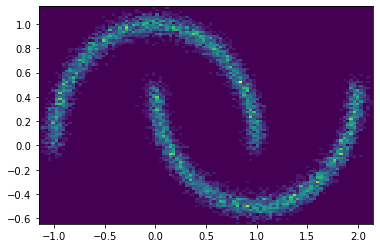

In [216]:
two_moons = get_two_moons(0.05)

rng_key = jax.random.PRNGKey(seed=0)
samps = two_moons.sample(10000, seed=rng_key)

# Plotting samples
hist2d(samps[:,0], samps[:,1],100);

In [217]:
# But now we can also compute the gradients of log p :-)
score = jax.vmap(jax.grad(two_moons.log_prob))

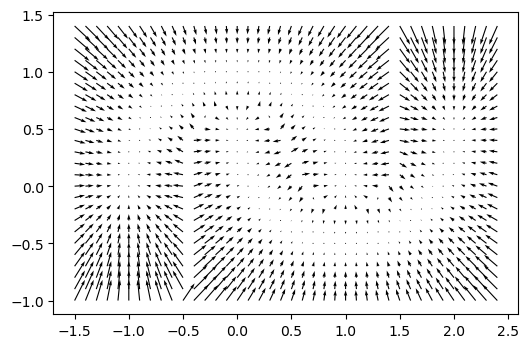

In [218]:
# Close up
figure(dpi=100)
X = np.arange(-1.5, 2.5, 0.1)
Y = np.arange(-1, 1.5, 0.1)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))
g = score(points).reshape([len(Y), len(X),2])

quiver(X, Y, g[:,:,0], g[:,:,1])

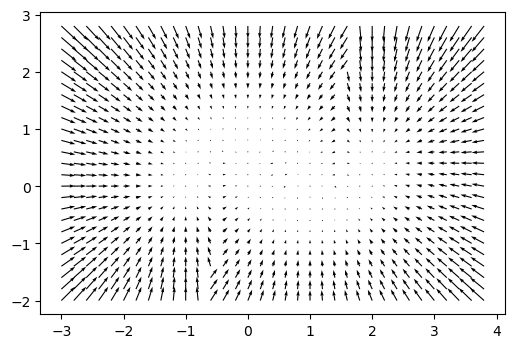

In [219]:
# Large scale
figure(dpi=100)
X = np.arange(-3, 4, 0.2)
Y = np.arange(-2, 3, 0.2)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))
g = score(points).reshape([len(Y), len(X),2])

quiver(X, Y, g[:,:,0], g[:,:,1])

## Implementing AR-DAE 

In [191]:
import haiku as hk
from jax.experimental import optix

class Denoiser(hk.Module):
    def __init__(self, is_training=False):
        super(Denoiser, self).__init__()
        self.is_training=is_training
    
    def __call__(self, x, sigma):
        sigma = sigma.reshape((-1,1))
        # Encoder
        net = hk.Linear(128)(jnp.concatenate([x, sigma],axis=1))
        net = hk.BatchNorm(True, True, 0.9)(net, self.is_training)
        net = jax.nn.leaky_relu(net)
        net = hk.Linear(128)(net)
        net = hk.BatchNorm(True, True, 0.9)(net, self.is_training)
        net = jax.nn.leaky_relu(net)
        net = hk.Linear(2)(net)
        
        # Decoder
        net = hk.Linear(128)(jnp.concatenate([net, sigma],axis=1))
        net = hk.BatchNorm(True, True, 0.9)(net, self.is_training)
        net = jax.nn.leaky_relu(net)
        net = hk.Linear(128)(net)
        net = hk.BatchNorm(True, True, 0.9)(net, self.is_training)
        net = jax.nn.leaky_relu(net)
        net = hk.Linear(2)(net)
        
        return net

In [192]:
def forward(x, sigma, is_training=False):
    denoiser = Denoiser(is_training=is_training)
    return denoiser(x, sigma)

model_train = hk.transform_with_state(partial(forward, is_training=True))

In [193]:
batch_size = 512
delta = 0.05

def get_batch(rng_key):
    y = two_moons.sample(batch_size, seed=rng_key)
    u = onp.random.randn(batch_size, 2)
    s = delta * onp.random.randn(batch_size, 1)
    x = y + s * u
    # x is a noisy sample, y is a sample from the distribution
    # u is the random normal noise realisation
    return {'x':x, 'y':y, 'u':u, 's':s}

In [194]:
optimizer = optix.adam(1e-3)
rng_seq = hk.PRNGSequence(42)

In [195]:
@jax.jit
def loss_fn(params, state, rng_key, batch):
    res, state = model_train.apply(params,  state, rng_key, 
                                   batch['x'], batch['s'])
    loss = jnp.mean((batch['u'] + batch['s'] * res)**2)
    return loss, state

In [196]:
@jax.jit
def update(params, state, rng_key, opt_state, batch):
    (loss, state), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, state, rng_key, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optix.apply_updates(params, updates)
    return loss, new_params, state, new_opt_state

In [197]:
params, state = model_train.init(next(rng_seq), 
                                 jnp.zeros((1, 2)), 
                                 jnp.ones((1, 1)))
opt_state = optimizer.init(params)
losses = []

In [198]:
for step in range(2000):
    batch = get_batch(next(rng_seq))
    loss, params, state, opt_state = update(params, state, next(rng_seq), opt_state, batch)
    losses.append(loss)
    if step%100==0:
        print(step, loss)

0 1.0300183
100 1.0255406
200 0.9159409
300 0.9580437
400 0.9820037
500 0.8147074
600 0.85602367
700 0.8841132
800 0.88761234
900 0.88936317
1000 0.8474066
1100 0.8267065
1200 0.86271363
1300 0.81118375
1400 0.83815217
1500 0.81763124
1600 0.79733837
1700 0.8457775
1800 0.8552306
1900 0.80381143


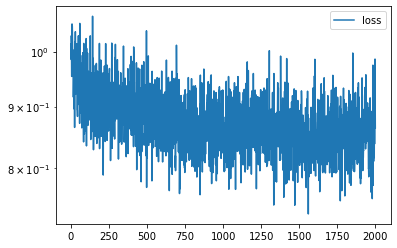

In [199]:
semilogy(np.array(losses[:]), label='loss')
legend()

In [220]:
X = np.arange(-1.5, 2.5, 0.1)
Y = np.arange(-1, 1.5, 0.1)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))

model = hk.transform_with_state(partial(forward, is_training=False))
score = partial(model.apply, params, state, next(rng_seq))

In [221]:
res, state = score(points, 0.0*jnp.ones((len(points),1)))

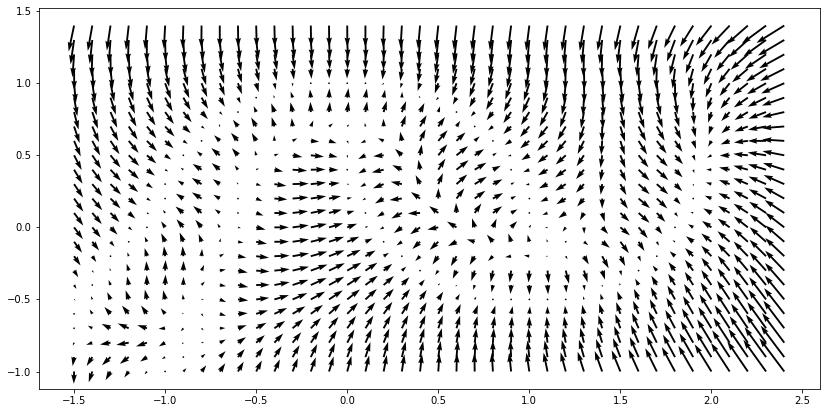

In [222]:
g = res.reshape([len(Y), len(X),2])
figure(figsize=(14,7))
quiver(X, Y, g[:,:,0], g[:,:,1])

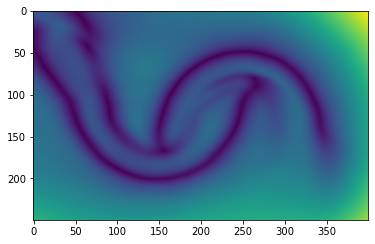

In [223]:
X = np.arange(-1.5, 2.5, 0.01)
Y = np.arange(-1, 1.5, 0.01)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))
res, state = score(points, jnp.zeros((len(points),1)))
g = res.reshape([len(Y), len(X),2])
imshow(np.sqrt(g[:,:,0]**2 + g[:,:,1]**2))

In [224]:
X = np.arange(-3, 4, 0.2)
Y = np.arange(-2, 3, 0.2)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))

res, state = score(points, 0.0*jnp.ones((len(points),1)))

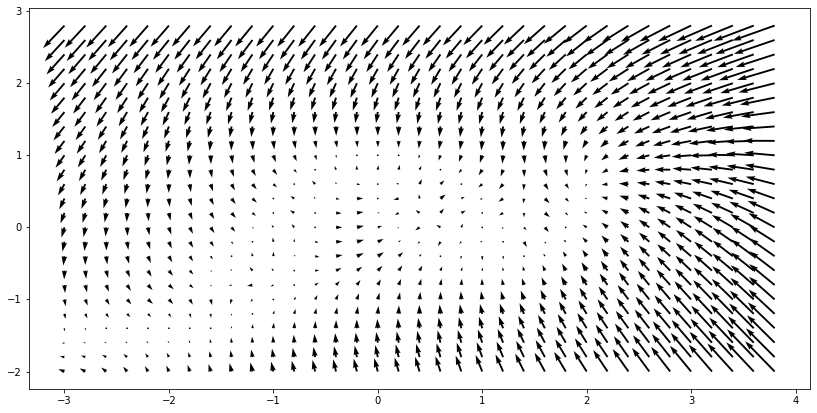

In [225]:
g = res.reshape([len(Y), len(X),2])
figure(figsize=(14,7))
quiver(X, Y, g[:,:,0], g[:,:,1])

## Adding Lipschitz regularisation

In [226]:
import haiku as hk
from jax.experimental import optix

class Denoiser(hk.Module):
    def __init__(self, is_training=False):
        super(Denoiser, self).__init__()
        self.is_training=is_training
    
    def __call__(self, x, sigma):
        sigma = sigma.reshape((-1,1))
        # Encoder
        net = hk.Linear(128)(jnp.concatenate([x, sigma],axis=1))
        net = hk.BatchNorm(True, True, 0.9)(net, self.is_training)
        net = jax.nn.leaky_relu(net)
        net = hk.Linear(128)(net)
        net = hk.BatchNorm(True, True, 0.9)(net, self.is_training)
        net = jax.nn.leaky_relu(net)
        net = hk.Linear(2)(net)
        
        # Decoder
        net = hk.Linear(128)(jnp.concatenate([net, sigma],axis=1))
        net = hk.BatchNorm(True, True, 0.9)(net, self.is_training)
        net = jax.nn.leaky_relu(net)
        net = hk.Linear(128)(net)
        net = hk.BatchNorm(True, True, 0.9)(net, self.is_training)
        net = jax.nn.leaky_relu(net)
        net = hk.Linear(2)(net)
        
        return net

In [227]:
def forward(x, sigma, is_training=False):
    denoiser = Denoiser(is_training=is_training)
    return denoiser(x, sigma)

model_train = hk.transform_with_state(partial(forward, is_training=True))

sn_fn = hk.transform_with_state(lambda x: hk.SNParamsTree(ignore_regex='[^?!.]*b$')(x))

In [228]:
batch_size = 512
delta = 0.05

def get_batch(rng_key):
    y = two_moons.sample(batch_size, seed=rng_key)
    u = onp.random.randn(batch_size, 2)
    s = delta * onp.random.randn(batch_size, 1)
    x = y + s * u
    # x is a noisy sample, y is a sample from the distribution
    # u is the random normal noise realisation
    return {'x':x, 'y':y, 'u':u, 's':s}

In [230]:
optimizer = optix.adam(1e-3)
rng_seq = hk.PRNGSequence(42)

In [231]:
@jax.jit
def loss_fn(params, state, rng_key, batch):
    res, state = model_train.apply(params,  state, rng_key, 
                                   batch['x'], batch['s'])
    loss = jnp.mean((batch['u'] + batch['s'] * res)**2)
    return loss, state

In [232]:
@jax.jit
def update(params, state, sn_state, rng_key, opt_state, batch):
    (loss, state), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, state, rng_key, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optix.apply_updates(params, updates)
    
    new_params, new_sn_state = sn_fn.apply(None, sn_state, None, new_params)
    
    return loss, new_params, state, new_sn_state, new_opt_state

In [235]:
params, state = model_train.init(next(rng_seq), 
                                 jnp.zeros((1, 2)), 
                                 jnp.ones((1, 1)))
opt_state = optimizer.init(params)
_, sn_state = sn_fn.init(jax.random.PRNGKey(1), params)

losses = []

In [236]:
for step in range(2000):
    batch = get_batch(next(rng_seq))
    loss, params, state, sn_state, opt_state = update(params, state, sn_state, next(rng_seq), opt_state, batch)
    losses.append(loss)
    if step%100==0:
        print(step, loss)

0 1.0067337
100 0.9280993
200 0.8574128
300 0.99839514
400 1.0330377
500 0.9615041
600 1.0216334
700 0.94970846
800 1.0125693
900 0.9720728
1000 0.94394237
1100 1.0310227
1200 1.0423625
1300 0.977699
1400 1.0169022
1500 0.9926747
1600 0.938272
1700 1.0080297
1800 0.9403002
1900 0.98398876


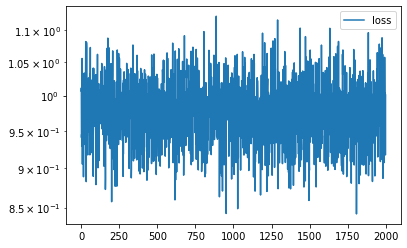

In [237]:
semilogy(np.array(losses[:]), label='loss')
legend()

In [238]:
X = np.arange(-1.5, 2.5, 0.1)
Y = np.arange(-1, 1.5, 0.1)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))

model = hk.transform_with_state(partial(forward, is_training=False))
score = partial(model.apply, params, state, next(rng_seq))

In [239]:
res, state = score(points, 0.0*jnp.ones((len(points),1)))

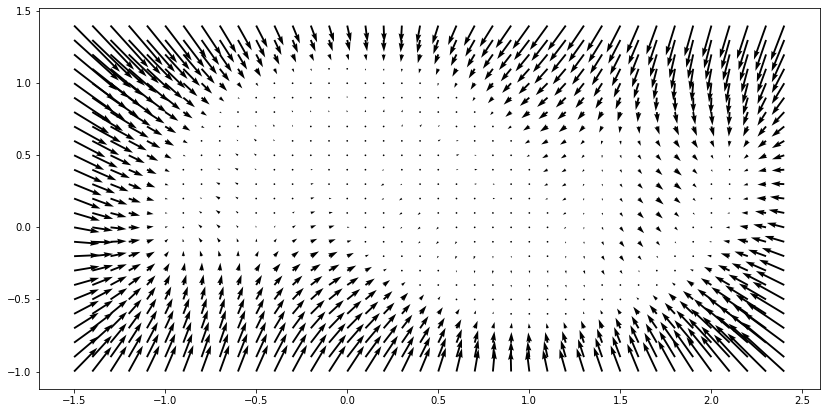

In [240]:
g = res.reshape([len(Y), len(X),2])
figure(figsize=(14,7))
quiver(X, Y, g[:,:,0], g[:,:,1])

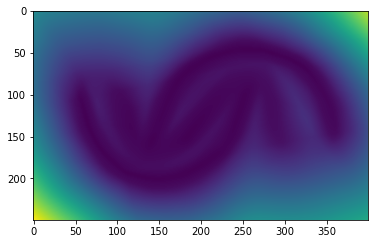

In [241]:
X = np.arange(-1.5, 2.5, 0.01)
Y = np.arange(-1, 1.5, 0.01)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))
res, state = score(points, jnp.zeros((len(points),1)))
g = res.reshape([len(Y), len(X),2])
imshow(np.sqrt(g[:,:,0]**2 + g[:,:,1]**2))

In [242]:
X = np.arange(-3, 4, 0.2)
Y = np.arange(-2, 3, 0.2)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))

res, state = score(points, 0.0*jnp.ones((len(points),1)))

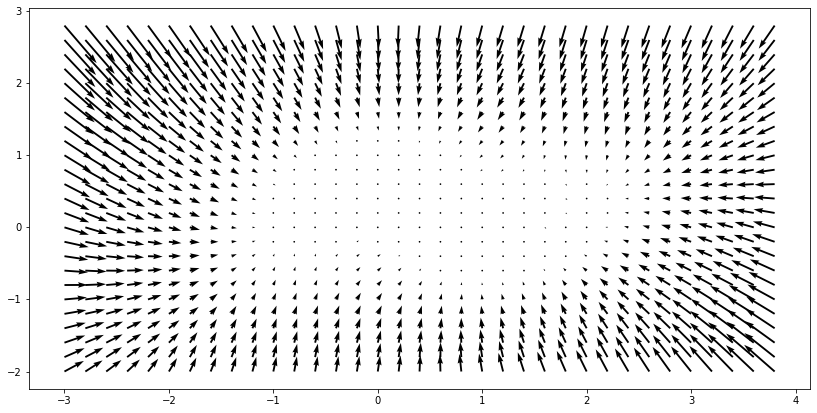

In [243]:
g = res.reshape([len(Y), len(X),2])
figure(figsize=(14,7))
quiver(X, Y, g[:,:,0], g[:,:,1])